# Capstone Project - Which Shoe is the Best for You?

General Assembly passion project. Scrape or obtain data from resources online to develop a dataset to perform cleaning, EDA, and analysis on. Try to predict a model on common themes like: 

- Price
- If item is in category A or B
- Cluster and create groups
- Recommender

- Predict lowest amount a shoe will sell for? So people know what price to wait for before buying?

---

### Tasks
1. Regression: Predict price (deadstock/retail) **OR** rarity of a shoe based on color, brand, desc, *reviews from Amazon?*, etc. 
    - Feature Selection
2. Classification: Predict if shoe will be a rare (hot) shoe? - So if a new shoe with similar features come out, would it be rare or not?
3. Make a recommendation based on clusters

### Notes
- Describe what deadstock price means
- Maybe make construction material from category?
- Trends - black or white shoes more popular
- what is a good investment (category, color, etc.)? Return biggest bang for buck
- Look for sales and volume data

---

### Reaches
image recognition?

python neural net libraries
tensorflow

Convolutional neural nets (cnn)

fast.ai

If pictures are well-framed, way to convert to a rgb dataframe
############## MNIST digit recognition for python ####################

could use pca at the end

Have to use AWS

Narrative: I'm bad at noticing shoe brands. what is this?

Augment: cluster on visual properties on shoes

In [1]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from time import sleep, strftime
import ast
from os import listdir

%matplotlib inline
%load_ext autotime

**Testing one website and finding appropriate keys**

Then run again on page 2.

In [2]:
result = requests.get('https://stockx.com/api/browse?page=1&category=152')
json_res = result.json()

time: 353 ms


In [3]:
result = requests.get('https://stockx.com/api/browse?page=2&category=152')
json_res = result.json()
print json_res['Products'][0]['shortDescription']
print json_res['Products'][0]['retailPrice']

Adidas-NMD-R1-Mystery-Blue
130
time: 400 ms


In [4]:
# Valuable information in the market section
json_res['Products'][0]['market']

{u'absChangePercentage': 0,
 u'annualHigh': 293,
 u'annualLow': 100,
 u'averageDeadstockPrice': 165,
 u'averageDeadstockPriceRank': 47,
 u'changePercentage': 0,
 u'changeValue': 0,
 u'createdAt': u'2017-02-22T00:24:31+00:00',
 u'deadstockRangeHigh': 134,
 u'deadstockRangeLow': 96,
 u'deadstockSold': 497,
 u'deadstockSoldRank': 24,
 u'highestBid': 121,
 u'lastHighestBidTime': 1499063579,
 u'lastLowestAskTime': 1498790021,
 u'lastSale': 115,
 u'lastSaleDate': u'2017-07-05T17:18:17+00:00',
 u'lowestAsk': 120,
 u'pricePremium': -0.115,
 u'pricePremiumRank': 90,
 u'productId': 0,
 u'productUuid': u'94aa6805-ac93-47d1-90e3-889aab20be6a',
 u'salesLast72Hours': 31,
 u'salesLastPeriod': 0,
 u'salesThisPeriod': 31,
 u'skuUuid': None,
 u'updatedAt': 1499273827,
 u'volatility': 0.165039}

time: 9 ms


### Functions to run for loop to scrape website

First function scrapes the web for an amount of pages (default 50). It will save the raw data as a csv as well. The second function will then clean the dataframe by taking out the unused columns.

In [5]:
def shoe_scraper(pages=50):
    '''Returns one dataframe of all results. And will save into a new file.'''
    
    # Have to run requests first to get appropriate column names
    req = requests.get('https://stockx.com/api/browse?page=1&category=152')
    json_req = req.json()
    df = pd.DataFrame([], columns=json_req['Products'][0].keys())

    for i in range(1,pages):
        try:
            html = 'https://stockx.com/api/browse?page=' + str(int(i)) + '&category=152'
            result = requests.get(html)
            json_res = result.json()
            df = pd.concat([df, pd.DataFrame(json_res['Products'])])
            sleep(0.5)
        except:
            break
    
    # Drop row duplicates
    df.drop_duplicates(['shortDescription', 'urlKey'], inplace=True) 
    
    # Function to save as csv file under today's day as raw (before dropping)
    def csv_maker(df):
        filename = 'StockX_' + strftime("%m%d%H")
        df.to_csv(path_or_buf='C:\\Users\\Chris\\Desktop\\dsi-atl-3\\project\\Capstone\\datasets\\' + filename, encoding='utf-8')
    
    csv_maker(df)
    
    return df

time: 15 ms


In [6]:
def clean_df(busy_dataframe):
    '''Dropping columns that hold little to no information. Combining columns with relevant info.
    Then reset the index since we are getting repeated indices'''
    
    # Market DataFrame. If scraping, comes in ready form
    # If pulling from old data, dictionary comes in string form
    if isinstance(busy_dataframe.market.reset_index(drop=True)[0], str):
        market_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['market']])
    else:
        market_df = pd.DataFrame([row for row in busy_dataframe['market']])
        
    # Same, but for including link for images
    if isinstance(busy_dataframe.media.reset_index(drop=True)[0], str):
        media_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['media']])['thumbUrl']
    else:
        media_df = pd.DataFrame([row for row in busy_dataframe['media']])['imageUrl']
    
    # Combine dataframes and drop unnecessary columns
    cleaner_dataframe = busy_dataframe.join(market_df)
    cleaner_dataframe = cleaner_dataframe.join(media_df)
    
    cleanest_dataframe = cleaner_dataframe.drop(['breadcrumbs', 'childId', 'countryOfManufacture', 'type', 
        'uuid', 'dataType', 'doppelgangers', 'condition', 'description', 'hidden', 'ipoDate', 'productCategory', 
        'shoeSize', 'urlKey', 'charityCondition', 'releaseTime', 'shortDescription', 'media', '_highlightResult', 
        'market', '_tags', 'id', 'objectID', 'lastHighestBidTime', 'lastLowestAskTime', 'styleId', 'productId',
        'productUuid', 'skuUuid', 'updatedAt', 'traits', 'tickerSymbol', 'salesLastPeriod',
        'minimumBid', 'averageDeadstockPriceRank', 'deadstockSoldRank', 'pricePremium', 'pricePremiumRank',
        'salesThisPeriod'], axis=1)
    
    # Reset the index, since we are getting repeated indices
    cleanest_dataframe.reset_index(drop=True, inplace=True)
    
    return cleanest_dataframe

time: 22 ms


### Run scrape on website
Use functions to read all previously saved csv files into one dataframe and do some preliminary cleaning. For now, only using the first duplicate. Trying to use last duplicate results in some weird prices, but are more up-to-date. **Try to figure out way to get most up-to-date observations.**

Finally, set up dataframe.

---

In [7]:
scraped_shoe = shoe_scraper()

time: 45.5 s


In [8]:
def read_and_clean(path):
    '''Read a file path where datasets are stored. Cleans the dataframe by removing duplicates,
    removing first column (Unnamed: 0) to be ready for clean_df function.'''
    file_list = listdir(path)
    file_list.remove('dataio')
    
    # Make a list of all the dataframes
    parts_df = [pd.read_csv('../datasets/' + files) for files in file_list]
    
    # Make one dataframe, take out first column and drop duplicates based on 'urlkey'
    df = pd.concat(parts_df)
    df = df.iloc[:,1:]
    df.drop_duplicates(['uuid'], inplace=True)#, keep='last')
    
    # Clean Brand names
    df.brand = df.brand.map(lambda x: x.title())
    
    # Lastly, change 'nan' to np.nan.
    df = df.applymap(lambda x: np.nan if x=='nan' else x)

    return df

time: 9 ms


In [9]:
path = '../datasets/'

shoe = clean_df(read_and_clean(path))

time: 1.89 s


### Dataframe is set
Some initial cleaning and EDA will need to be done.
- Drop nulls
- Change time series into datetime if possible
- Check out the shape
- Drop the error value for the high bid > $20,000

**Make a metric for rarity: average Deadstock Price / retail Price**

In [10]:
# Some cleaning first. Take out null rows and change time data to date time
shoe.dropna(inplace=True)
shoe['releaseDate'] = pd.to_datetime(shoe.releaseDate).dt.date
shoe['year'] = shoe.year.map(lambda x: int(x))
shoe['createdAt'] = pd.to_datetime(shoe.createdAt).dt.date
shoe.shape

(1888, 26)

time: 40 ms


In [11]:
# # Dropping value for highestbid.max() because API saves it as > $20,000
# mistake_ind = shoe[shoe.highestBid == shoe.highestBid.max()].index
# shoe.drop(mistake_ind, axis=0, inplace=True)
# shoe.reset_index(inplace=True, drop=True)

time: 2 ms


In [12]:
# New metric for rarity of shoe
shoe['rarity'] = shoe.averageDeadstockPrice/shoe.retailPrice

# Since shoes retailed at $0 doesn't fit into the scope of the project, drop them.
infinity_ind = shoe[shoe.retailPrice==0].index
shoe.drop(infinity_ind, axis=0, inplace=True)
shoe.reset_index(inplace=True, drop=True)

# Most 'rare' shoes
shoe[['title', 'year', 'retailPrice', 'averageDeadstockPrice', 'highestBid', 'rarity']].sort_values('rarity', ascending=False).head()

,title,year,retailPrice,averageDeadstockPrice,highestBid,rarity
1613,Nike Dunk SB Low Supreme NY Black Cement (2002),2002,65.0,1388,1000,21.353846
1723,Nike SB Dunk High Momofuku,2017,110.0,1706,1336,15.509091
1537,Jordan 1 Retro Low OG Ice Blue,2017,140.0,1936,3037,13.828571
1724,Air Max 1 Air Max Day 3.26,2014,125.0,1706,1336,13.648000
1254,Nike Dunk SB High Tie Dye Black,2014,108.0,1447,1000,13.398148


time: 41 ms


(-5, 1500)

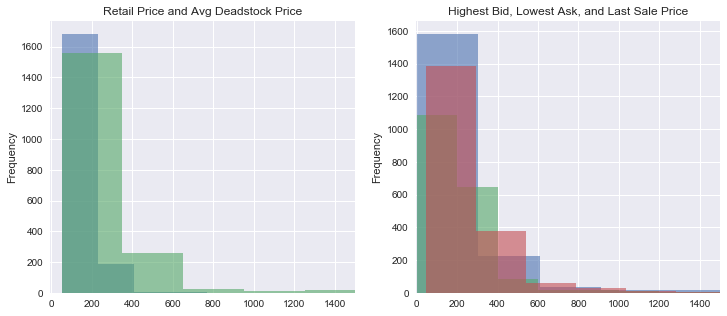

time: 488 ms


In [13]:
# Plots for general overview
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

shoe.retailPrice.plot(kind='hist', alpha=0.6, ax=ax1)
shoe.averageDeadstockPrice.plot(kind='hist', alpha=0.6, ax=ax1)
ax1.set_title('Retail Price and Avg Deadstock Price')
ax1.axes.set_xlim(-5, 1500)

shoe.highestBid.plot(kind='hist', alpha=0.6, ax=ax2)
shoe.lowestAsk.plot(kind='hist',alpha=0.6, ax=ax2)
shoe.lastSale.plot(kind='hist', alpha=0.6, ax=ax2)
ax2.set_title('Highest Bid, Lowest Ask, and Last Sale Price')
ax2.axes.set_xlim(-5,1500)

In [14]:
# A view of the most expensive bid on shoe.
shoe[shoe.highestBid > 2000][['shoe', 'colorway', 'lastSale', 'highestBid', 'averageDeadstockPrice', 'retailPrice']].sort_values('highestBid', ascending=False)

,shoe,colorway,lastSale,highestBid,averageDeadstockPrice,retailPrice
1535,Adidas Ultra Boost,Adidas-Ultra-Boost-Miami-Hurricanes,2515,3037,1936,180.0
1536,Nike Air Max 90,White/White,2515,3037,1936,160.0
1537,Jordan 1 Retro Low OG,Ice Blue/Vachetta Tan-White,2515,3037,1936,140.0
373,Jordan 1 Retro,Black/Sport Blue-White,1605,3000,1696,185.0
620,Adidas Yeezy Boost 750,Brown/Carbon White-Light Brown,2500,2125,3059,350.0
259,Adidas Yeezy Boost 350,Turtledove/Blue Grey-White,2100,2050,2223,200.0
352,Adidas NMD,EQT Yellow/EQT Yellow/FTWR White,2001,2050,828,240.0


time: 25 ms


In [15]:
# A view at the most highest retailed shoe. Strangely enough, it is not in the top 7 highest bid.
shoe[shoe.retailPrice == shoe.retailPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year']]

,shoe,colorway,name,retailPrice,year
1573,Air Yeezy 2,Gold/White,John Geiger x LASCO Golden Child,1850.0,2016


time: 15 ms


In [16]:
# A look at the highest average deadstock price
shoe[shoe.averageDeadstockPrice == shoe.averageDeadstockPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year', 'averageDeadstockPrice']]

,shoe,colorway,name,retailPrice,year,averageDeadstockPrice
620,Adidas Yeezy Boost 750,Brown/Carbon White-Light Brown,OG Light Brown,350.0,2015,3059


time: 13 ms


In [17]:
# A look at the highest last sale price
shoe[shoe.lastSale == shoe.lastSale.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year', 'lastSale']]

,shoe,colorway,name,retailPrice,year,lastSale
1535,Adidas Ultra Boost,Adidas-Ultra-Boost-Miami-Hurricanes,Miami Hurricanes,180.0,2016,2515
1536,Nike Air Max 90,White/White,Laser NYC,160.0,2016,2515
1537,Jordan 1 Retro Low OG,Ice Blue/Vachetta Tan-White,Ice Blue,140.0,2017,2515


time: 18 ms


In [18]:
shoe.describe()

,retailPrice,year,absChangePercentage,annualHigh,annualLow,averageDeadstockPrice,changePercentage,changeValue,deadstockRangeHigh,deadstockRangeLow,deadstockSold,highestBid,lastSale,lowestAsk,salesLast72Hours,volatility,rarity
count,1886.00000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,173.81018,2014.755037,0.205622,442.791092,169.014846,281.118240,0.001969,-11.931071,305.314422,207.016967,227.274655,222.511665,256.133086,230.519088,5.302227,0.200738,1.724871
std,76.17848,3.021130,0.228349,489.956420,136.235916,227.659426,0.307315,103.660001,272.026897,182.506639,441.850006,243.634994,224.423644,195.579019,23.076229,0.135553,1.458696
min,50.00000,1985.000000,0.000000,50.000000,11.000000,50.000000,-0.666667,-1058.000000,55.000000,-18.000000,1.000000,0.000000,45.000000,0.000000,1.000000,0.000000,0.135135
25%,140.00000,2014.000000,0.045455,246.250000,100.000000,173.000000,-0.163636,-42.000000,176.000000,111.000000,22.000000,110.000000,149.000000,140.000000,1.000000,0.122968,1.050357
50%,160.00000,2016.000000,0.139130,325.000000,140.000000,227.000000,0.000000,0.000000,238.000000,167.000000,78.000000,175.000000,200.000000,185.000000,2.000000,0.177207,1.383772
75%,190.00000,2017.000000,0.302222,471.000000,191.000000,311.000000,0.106454,21.000000,349.000000,245.000000,238.750000,250.000000,300.000000,250.000000,4.000000,0.248585,1.868391
max,1850.00000,2017.000000,2.529412,8550.000000,1715.000000,3059.000000,2.529412,549.000000,3693.000000,1900.000000,5579.000000,3037.000000,2515.000000,2000.000000,916.000000,1.362362,21.353846


time: 66 ms


### Descriptions of some columns

- deadstockRangeHigh = highest price of deadstock within the last 12 mo.
- deadstockRangeLow = lowest price of deadstock within the last 12 mo.
- highestBid = highest price someone is bidding, or willing to pay
- lowestAsk = lowest price someone is currently asking for, or selling
- rarity = averageDeadstockPrice / retailPrice
- lastSale = Last price product was sold for sourced from ebay, twitter, etc.
---
### Make a dataframe with only the top brands: Nike, Jordan, Adidas
Scale the dataframe down so that not too many outside brands are taking the focus away from the main goal of the project.

---

In [19]:
shoe.brand.value_counts()[:5]

Nike      695
Jordan    620
Adidas    444
Asics      38
Vans       25
Name: brand, dtype: int64

time: 16 ms


In [295]:
# Concerned with only the top brands
tops = shoe[(shoe.brand=='Adidas')|(shoe.brand=='Nike')|(shoe.brand=='Jordan')]
tops.reset_index(drop=True, inplace=True)

time: 8 ms


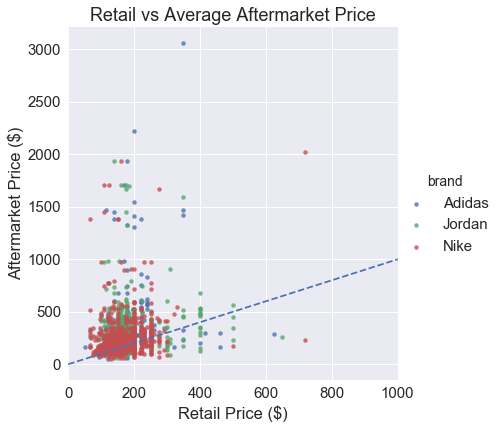

time: 326 ms


In [21]:
# See a 1-to-1 linear line for retail Price vs last Sale price
sns.set(font_scale=1.5)
sns.lmplot(x='retailPrice', y ='averageDeadstockPrice', data=tops, hue='brand', fit_reg=False, size=6,
          scatter_kws={"s": 20})
plt.plot(np.linspace(0,2000,2000), np.linspace(0,2000,2000), linestyle='--')
plt.xlim([0,1000])
plt.title('Retail vs Average Aftermarket Price')
plt.xlabel('Retail Price ($)')
plt.ylabel('Aftermarket Price ($)')
plt.show()

In [22]:
# sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2010], hue='brand')
# plt.xticks(rotation=90)
# plt.show()

time: 2 ms


In [23]:
# # Adidas didn't really come into the market until 2015. Let's look more closely
# sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2014], hue='brand')
# plt.legend(loc='best')
# plt.xlabel('Year')
# plt.ylabel('Last Sold Price ($)')
# plt.title('Top Product Aftermarket Sales Price')
# plt.show()

time: 22 ms


### After some market research, Adidas came into the sneakerhead culture because of two products: the Adidas Boost and the Adidas Yeezy's

Nike was first partnered with Kanye West for making a collaborative shoe. But after his contract ended, Mr. West changed sides to Adidas, who previously was widely known for their athletic shoes (for soccer and football) rather than collectible sneakers.

---

In [24]:
# Adidas boost's came out in January 2015 along with Yeezy's in February of 2015
tops[(tops.brand=='Adidas') & (tops.shoe.str.contains('boost', case=False))].shape

(175, 27)

time: 16 ms


In [25]:
# Adidas and Nike Yeezy's
tops[tops.shoe.str.contains('yeezy',case=False)].shape

(30, 27)

time: 11 ms


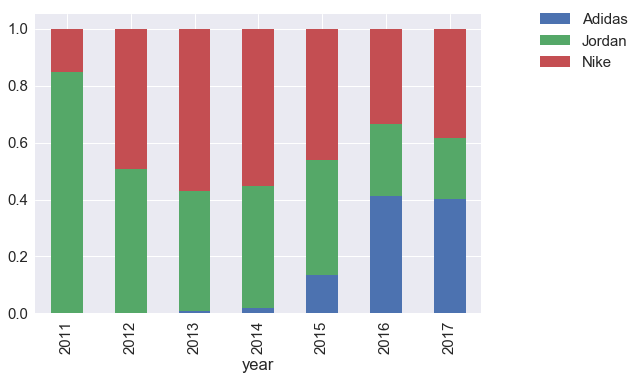

brand,Adidas,Jordan,Nike
year,,,
2011,0.000000,0.846154,0.153846
2012,0.000000,0.507042,0.492958
2013,0.009346,0.420561,0.570093
2014,0.018072,0.427711,0.554217
2015,0.135371,0.401747,0.462882
2016,0.411232,0.253623,0.335145
2017,0.401766,0.214128,0.384106


time: 232 ms


In [26]:
# Did Adidas increase market share (on StockX)?
sub_tops = tops[tops.year>2010].groupby(['year', 'brand'])['brand'].count().unstack().fillna(0)
sub_tops = sub_tops.T
sub_tops = sub_tops.div(sub_tops.sum())
sub_tops = sub_tops.T

sub_tops.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()
sub_tops

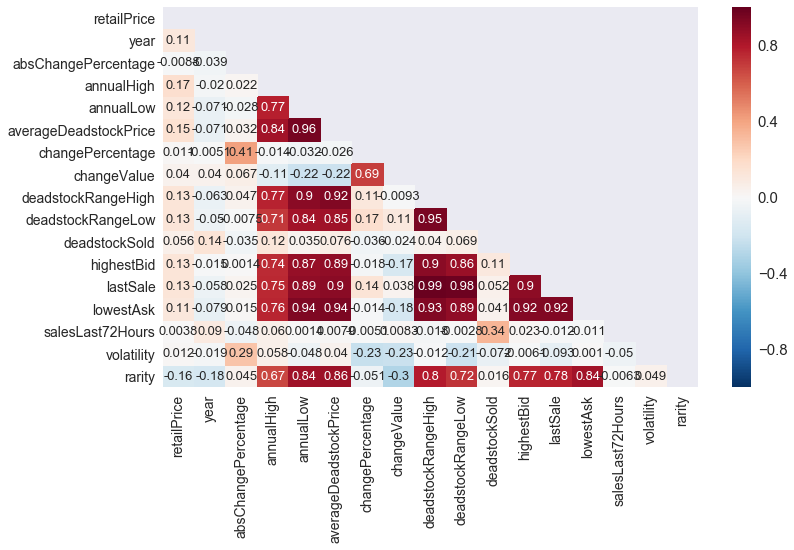

time: 822 ms


In [27]:
# Set init variables
corr = tops.corr()

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(12,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, annot=True, annot_kws={"size":13}, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation='vertical')
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

# Analysis time:


In [28]:
# Import everything
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.metrics import accuracy_score, completeness_score, silhouette_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

time: 5 s


In [99]:
# Maybe the colorway is an indicator of averageDeadstockPrice
snow = SnowballStemmer('english')

# placeholder = pd.Series('Colorway_token')
placeholder = pd.Series(tops.colorway.apply(lambda x: x.replace("/"," ").replace('-',' ').split(" ")))

# Maybe make vectors for each primary color?

tops['colorway_token'] = placeholder.apply(lambda x: " ".join([snow.stem(y) for y in x]))

time: 260 ms


C:\Users\Chris\Anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [235]:
# do nlp vectorizers now?

# Making a rarity boolean for those above median
tops['rarity_bool'] = tops.rarity.map(lambda x: 1 if x >= 1.75 else 0)
y = tops.rarity_bool

time: 102 ms


C:\Users\Chris\Anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [254]:
baseline = max(1 - y.mean(), y.mean())
print baseline

0.712336554861
time: 4 ms


In [238]:
X = tops.colorway_token

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=90)

time: 3 ms


In [239]:
# Going to try several vectorizers and models. Better to write a function that will do this in one step.
def tokenize_test(text, vect, model, target='rarity_bool', 
                  X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    '''Arguments are text, vect, model, target (in strings)
    X_train, X_test, y_train, y_test.
    Used to find the accuracy of the rarity.'''
    X = tops[text]
    y = tops[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=90)
    X_train_dtm = vect.fit_transform(X_train)
    
    X_test_dtm = vect.transform(X_test)
    model.fit(X_train_dtm, y_train)
    y_pred_class = model.predict(X_test_dtm)
    return accuracy_score(y_test, y_pred_class)

time: 10 ms


In [248]:
# Making a function to make a dataframe for the accuracy results of tokenize_test
def accuracy_df_maker(models, vectors, texts, target):
    '''models and vectors are dictionarys with key as the label and value as the object.
    texts is a list of features to test on. Returns a sorted dataframe with accuracy scores
    of every model, vectorizer, and feature combintion'''
    Accuracy_scores = []
    for model_k, model_v in models.items():
        for vect_k, vect_v in vectors.items():
            for text in texts:
                Accuracy_scores.append((model_k, vect_k, text, tokenize_test(text, vect_v, model_v, target)))
    
    df = pd.DataFrame(Accuracy_scores, columns=['Model', 'Vectorizer', 'Feature', 'Accuracy_score'])
    return df.sort_values('Accuracy_score', ascending=False).reset_index(drop=True)

time: 9 ms


In [249]:
ng = (1,3)
cvec, hvec, tvec = CountVectorizer(ngram_range=ng), HashingVectorizer(ngram_range=ng), TfidfVectorizer(ngram_range=ng)

models = {'SVC':SVC(), 'Log':LogisticRegression(), 'Bernoulli':BernoulliNB(), 'KNN':KNeighborsClassifier()}
vectors = {'CVEC':cvec, 'HVEC':hvec, 'TVEC': tvec}
texts = ['colorway_token', 'category', 'title', 'name']

time: 6 ms


In [250]:
nlp = accuracy_df_maker(models, vectors, texts, 'rarity_bool')
nlp.head()

,Model,Vectorizer,Feature,Accuracy_score
0,Log,TVEC,name,0.744318
1,Log,TVEC,title,0.741477
2,Log,HVEC,name,0.738636
3,Log,HVEC,title,0.735795
4,SVC,HVEC,colorway_token,0.724432


time: 5.5 s


In [252]:
# Separate functions because random forst with hashing takes more than 3 minutes with worse results.
# Same with Multinomial. Combining all into one dataframe, best_df

nlp_add = accuracy_df_maker({'Random Forest':RandomForestClassifier(), 'Multinomial':MultinomialNB()}, 
                            {'CVEC':cvec, 'TVEC':tvec}, ['colorway_token', 'category', 'title', 'name'], 'rarity_bool')
best_df = pd.concat([nlp, nlp_add]).sort_values('Accuracy_score', ascending=False).reset_index(drop=True).copy()

time: 2.49 s


In [485]:
print baseline
best_df[best_df.Accuracy_score > baseline*1.02]

0.712336554861


,Model,Vectorizer,Feature,Accuracy_score
0,Log,TVEC,name,0.744318
1,Log,TVEC,title,0.741477
2,Log,HVEC,name,0.738636
3,Log,HVEC,title,0.735795
4,Multinomial,TVEC,title,0.727273


time: 25 ms


### Now time to do regression on ________ using PCA

---

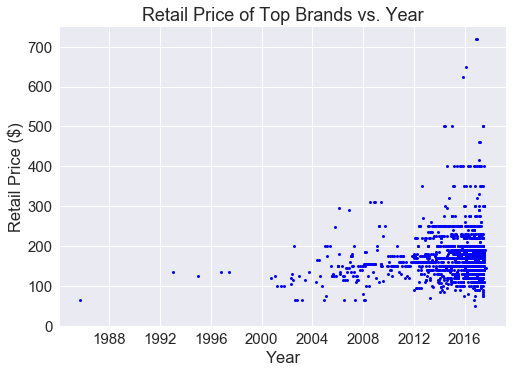

time: 191 ms


In [31]:
# Try doing times series of release date vs. retailprice/averageDeadstockPrice
cops = tops.set_index('releaseDate').sort_index()

plt.plot(cops.retailPrice, 'bo', markersize=3)
# plt.plot(cops.averageDeadstockPrice, 'r*', markersize=3)
plt.xlabel('Year')
plt.ylabel('Retail Price ($)')
plt.title('Retail Price of Top Brands vs. Year')
plt.ylim(0,750);

In [95]:
# cluster on category and price?
shoe.category.head()

0       adidas Yeezy
1         adidas NMD
2    Air Jordan Four
3       adidas Yeezy
4     Air Jordan One
Name: category, dtype: object

time: 6 ms


Information taken from https://pythonprogramming.net/automated-image-thresholding-python/?completed=/thresholding-python-function/

Deep Learning made possible via a VM by https://github.com/nirmalyaghosh/deep-learning-vm

Imaging code was sourced from http://pillow.readthedocs.io/en/3.4.x/reference/Image.html.

Pickling code was sourced from https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict

In [385]:
# only gathering images for those that have images
tops_with_pics = tops[tops.thumbUrl != '']
tops_with_pics.reset_index(drop=True, inplace=True)

time: 20 ms


In [457]:
pickled_array = []
counter = 0
for shoe_num in range(len(tops_with_pics)):
    fd =urllib.urlopen(tops_with_pics.thumbUrl[shoe_num])
    image_file = io.BytesIO(fd.read())
    i = Image.open(image_file).convert('RGB')
    iar = np.asarray(i)
    iar.setflags(write=1)
    
    pickled_array.append(iar)
    counter += 1
    if counter % 251 == 0:
        print shoe_num
    sleep(0.5)
    image_file.close()
    fd.close()

99
199
299
399
499
599
699
799
899
999
1099
1199
1299
1399
1499
1599
1699
time: 21min 13s


In [458]:
import pickle
with open('shoenumbers.pickle', 'wb') as handle:
    pickle.dump(pickled_array, handle, protocol=2)

time: 744 ms


In [475]:
with open('shoenumbers.pickle', 'rb') as handle:
    X = pickle.load(handle)

time: 258 ms


In [487]:
# Check shape of X
print np.array(X).shape
print np.array(X[0]).shape

(1747L, 200L, 280L, 3L)
(200L, 280L, 3L)
time: 690 ms


In [483]:
X = np.array(X)
X = X.astype('float32')

time: 621 ms


In [484]:
X /= 255.

time: 174 ms


In [486]:
# Make models in keras now....but how?









time: 2 ms


In [94]:
# Tresholding or making black and white
# import sys
# def threshold(imageArray):
#     balanceAr = []
#     newAr = imageArray
#     for eachRow in imageArray:
#         for eachPix in eachRow:
#             avgNum = reduce(lambda x, y: x + y, eachPix[:3]) / len(eachPix[:3])
#             balanceAr.append(avgNum)
#     balance = reduce(lambda x, y: x + y, balanceAr) / len(balanceAr)
#     for eachRow in newAr:
#         for eachPix in eachRow:
#             if reduce(lambda x, y: x + y, eachPix[:3]) / len(eachPix[:3]) > balance:
#                 eachPix[0] = 255
#                 eachPix[1] = 255
#                 eachPix[2] = 255
#                 eachPix[3] = 255
#             else:
#                 eachPix[0] = 0
#                 eachPix[1] = 0
#                 eachPix[2] = 0
#                 eachPix[3] = 255
#     return newAr

# i = Image.open('Nike-LeBron-3-West-Coast.png')

# iar = np.asarray(i)
# iar.setflags(write=1)

# iar_bw = threshold(iar)
# plt.imshow(iar_bw)
# plt.grid(False)

time: 5 ms
